In [35]:
%load_ext autoreload
%env PYTHONPATH=../

import sys
sys.path.append("../")

import os
print(os.environ["PYTHONPATH"])

import numpy as np
from tensorflow import keras
from oodeel.methods import MLS, DKNN, ODIN
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import OODDataset

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=../
../


## Two datasets experiment

In [36]:
%autoreload 2

oods_id = OODDataset('mnist', split="test")
oods_ood = OODDataset('fashion_mnist', is_ood=True, split="test")
oods_fit = OODDataset('mnist', split="train")
oods_test = oods_id.concatenate(oods_ood)

labels = oods_test.ood_labels

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


batch_size = 128
ds_test = oods_test.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, with_ood_labels=False)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, with_ood_labels=False, shuffle=True)

2023-02-24 21:07:18.053331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:07:19.090198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [37]:

model = tf.keras.models.load_model("../saved_models/mnist_model")

### MLS

2023-02-24 21:07:22.349046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:07:23.649904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.994483825, 'fpr95tpr': 0.023, 'accuracy_score': 0.9629, 'roc_auc_score': 0.99448376}


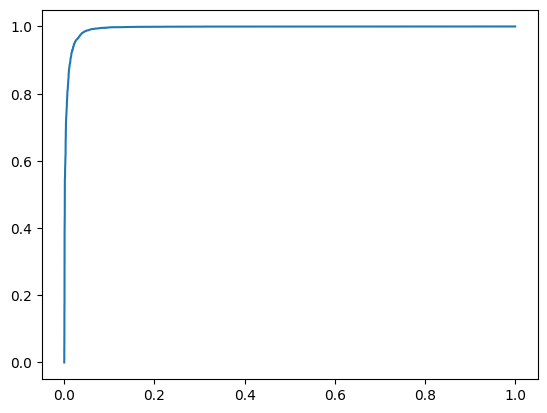

In [38]:

%autoreload 2


oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)

metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()


### DKNN

2023-02-24 21:07:27.234892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:07:31.192785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:07:49.555100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9986808250000001, 'fpr95tpr': 0.0044, 'accuracy_score': 0.5, 'roc_auc_score': 0.99868077}


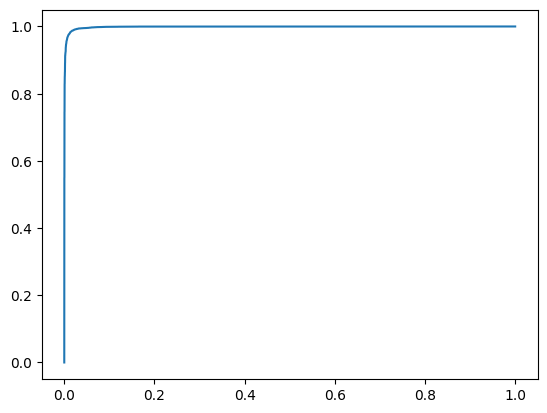

In [39]:
%autoreload 2


oodmodel = DKNN()
oodmodel.fit(model, ds_fit.take(10000))
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### ODIN

2023-02-24 21:07:51.294546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:07:51.529697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:07:54.481313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:07:54.655435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9946918650000001, 'fpr95tpr': 0.0216, 'accuracy_score': 0.97115, 'roc_auc_score': 0.9946919099999999}


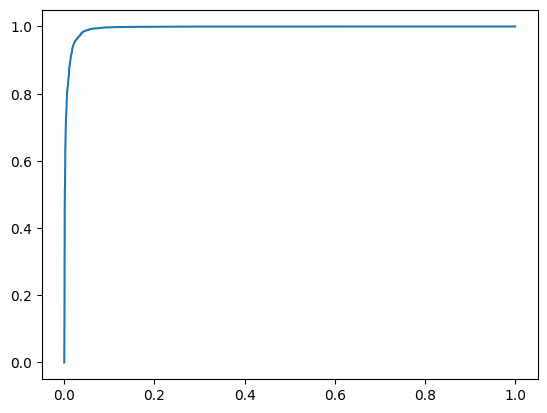

In [40]:

%autoreload 2
from oodeel.methods import ODIN

oodmodel = ODIN()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [41]:

%autoreload 2

oods_test = OODDataset('mnist', split="test")
oods_train = OODDataset('mnist', split="train")

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_id, _ = oods_train.assign_ood_labels_by_class(id_labels=inc_labels, return_filtered_ds=True)
oods_test.assign_ood_labels_by_class(id_labels=inc_labels)

labels = oods_test.ood_labels

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

ds_train = oods_id.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, 
with_ood_labels=False, shuffle_buffer_size=10000)
ds_test = oods_test.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_fit = oods_id.prepare(batch_size=batch_size, with_ood_labels=False,preprocess_fn=preprocess_fn, shuffle=True)


2023-02-24 21:07:57.271454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:01.553849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:04.834145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:08.452856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:11.558915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:12.541954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [42]:
%autoreload 2
from oodeel.models.training_funs import train_convnet_classifier

train_config = {
    "input_shape": (28, 28, 1),
    "num_classes": len(inc_labels),
    "is_prepared": True,
    "batch_size": 128,
    "epochs": 5
}

model = train_convnet_classifier(ds_train, **train_config)

2023-02-24 21:08:13.801895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5


2023-02-24 21:08:17.369354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 7s 23ms/step - loss: 0.2192 - accuracy: 0.9336
Epoch 2/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0460 - accuracy: 0.9867
Epoch 3/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0310 - accuracy: 0.9912
Epoch 4/5
240/240 [==============================] - 5s 21ms/step - loss: 0.0286 - accuracy: 0.9921
Epoch 5/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0275 - accuracy: 0.9927


## MLS

2023-02-24 21:08:45.089533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:46.058532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9404916895973885, 'fpr95tpr': 0.29538820782253356, 'accuracy_score': 0.8784, 'roc_auc_score': 0.940491889752076}


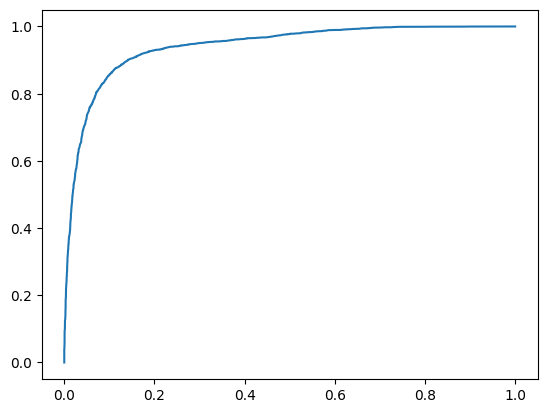

In [43]:
%autoreload 2

oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### DKNN

2023-02-24 21:08:49.615495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:51.499751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:57.048863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.971023846069196, 'fpr95tpr': 0.1257053901537264, 'accuracy_score': 0.4861, 'roc_auc_score': 0.9710248468426339}


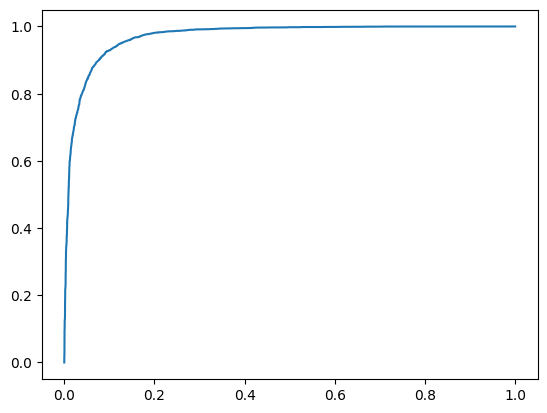

In [44]:
%autoreload 2

oodmodel = DKNN()
oodmodel.fit(model, ds_fit.take(10000))
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### ODIN

2023-02-24 21:08:58.272528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:08:58.490043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:09:00.189124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-24 21:09:00.416067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.942342239776589, 'fpr95tpr': 0.28137769994162287, 'accuracy_score': 0.8655, 'roc_auc_score': 0.9423418794981513}


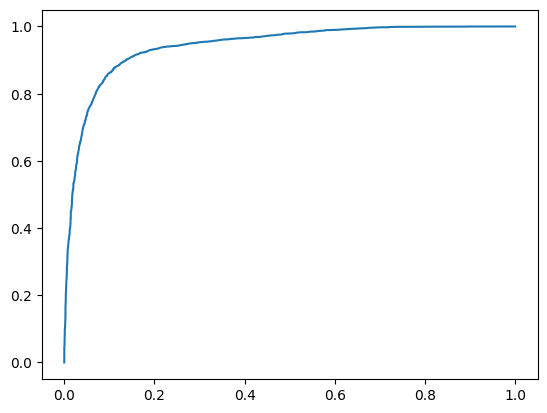

In [45]:
%autoreload 2

#x_test, y_id = data_handler.convert_to_numpy(x_id)

oodmodel = ODIN()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()